In [1]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import cv2
import statistics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def performance_metrics(image,GT):
    # Convert pixel values to floating point
    image = img_as_float(image)
    GT = img_as_float(GT)

    # Show images
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].invert_yaxis()
    ax[1].imshow(GT, cmap=plt.cm.gray)
    ax[1].invert_yaxis()

    # Statistics for histogram
    mode_image = statistics.mode(image.flatten())
    mode_GT = statistics.mode(GT.flatten())

    # Plot histrogram
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax = axes.ravel()

    ax[0].hist(image.flatten(), 255)
    mode_ = ax[0].vlines(mode_image,0,np.sum(image == mode_image),colors='red')
    median_ = ax[0].vlines(statistics.median(image.flatten()),0,np.sum(image == mode_image),colors='black')
    mean_ = ax[0].vlines(statistics.mean(image.flatten()),0,np.sum(image == mode_image),colors='yellow')
    ax[0].set_title('Pixel values for noisy image')
    ax[1].hist(GT.flatten(), 255)
    ax[1].vlines(mode_GT,0,np.sum(GT == mode_GT),colors='red')
    ax[1].vlines(statistics.median(GT.flatten()),0,np.sum(GT == mode_GT),colors='black')
    ax[1].vlines(statistics.mean(GT.flatten()),0,np.sum(GT == mode_GT),colors='yellow')
    ax[1].set_title('Pixel values for denoised image')
    plt.legend([mode_, median_, mean_],["Mode", "Median", "Mean"])
    plt.show()

    # Edge sharpness with Sobel
    # create convolved images
    ksize = -1
    gX1 = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    gY1 = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)
    gX2 = cv2.Sobel(GT, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    gY2 = cv2.Sobel(GT, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)

    # convert to unsigned integers
    gX1 = cv2.convertScaleAbs(gX1)
    gY1 = cv2.convertScaleAbs(gY1)
    gX2 = cv2.convertScaleAbs(gX2)
    gY2 = cv2.convertScaleAbs(gY2)

    # combine convolved images
    combined1 = cv2.addWeighted(gX1, 0.5, gY1, 0.5, 0)
    combined2 = cv2.addWeighted(gX2, 0.5, gY2, 0.5, 0)

    # plot
    fig, ax = plt.subplots(3,2,figsize=(12, 6))

    ax[0][0].imshow(gX1,cmap=plt.cm.gray)
    ax[0][0].invert_yaxis()
    ax[0][0].set_title('Noisy image \nVertical edge detection',size=10)
    ax[1][0].imshow(gY1,cmap=plt.cm.gray)
    ax[1][0].invert_yaxis()
    ax[1][0].set_title('Horizontal edge detection',size=10)
    ax[2][0].imshow(combined1,cmap=plt.cm.gray)
    ax[2][0].invert_yaxis()
    ax[2][0].set_title('Combined edge detection',size=10)
    ax[0][1].imshow(gX2,cmap=plt.cm.gray)
    ax[0][1].invert_yaxis()
    ax[0][1].set_title('Denoised image \nVertical edge detection',size=10)
    ax[1][1].imshow(gY2,cmap=plt.cm.gray)
    ax[1][1].invert_yaxis()
    ax[1][1].set_title('Horizontal edge detection',size=10)
    ax[2][1].imshow(combined2,cmap=plt.cm.gray)
    ax[2][1].invert_yaxis()
    ax[2][1].set_title('Combined edge detection',size=10)
    fig.subplots_adjust(hspace=0.5)

    # Calculate standard deviation of pixel values
    std_image = np.std(image)
    std_GT = np.std(GT)

    # Calculate mean squared error
    MSE = mean_squared_error(image, GT)
    # Calculate structural similarity index
    SSIM = ssim(image, GT,data_range=1)

    # Calculate the Laplacian variance
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    var_laplacian_image = np.var(laplacian)
    laplacian = cv2.Laplacian(GT, cv2.CV_64F)
    var_laplacian_GT = np.var(laplacian)

    print('Mean square error between noisy image and denoised image:',MSE)
    print('Structural similarity index between noisy image and denoised image', SSIM)
    print('-'*130)
    print('Standard deviation of pixel values in noisy image:',std_image)
    print('Standard deviation of pixel values in denoised image:',std_GT)
    print('-'*130)
    print('Variance of Laplacian of noisy image',var_laplacian_image)
    print('Variance of Laplacian of denoised image',var_laplacian_GT)

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


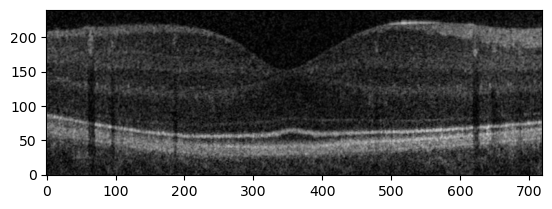

In [4]:
import imageio.v3 as iio

# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

Image name (shape) (intensity max, min, mean, std)

averaged (240, 720) (182, 5, 49.4, 32.4)


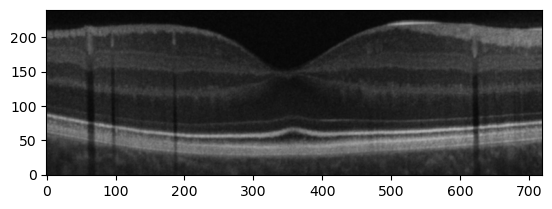

In [5]:
# Global variables

IMAGE_DIR = 'images'
IMAGE_NAME='averaged'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

GT = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

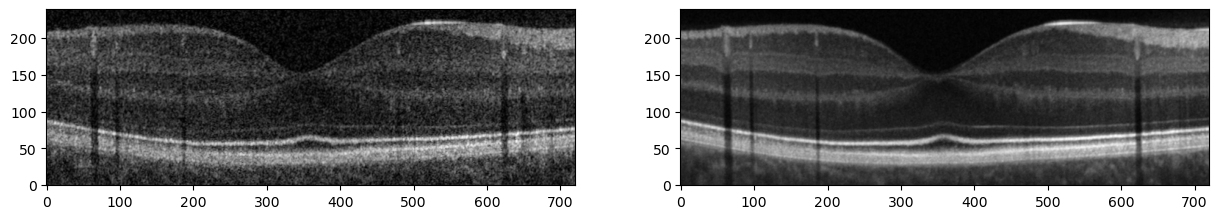

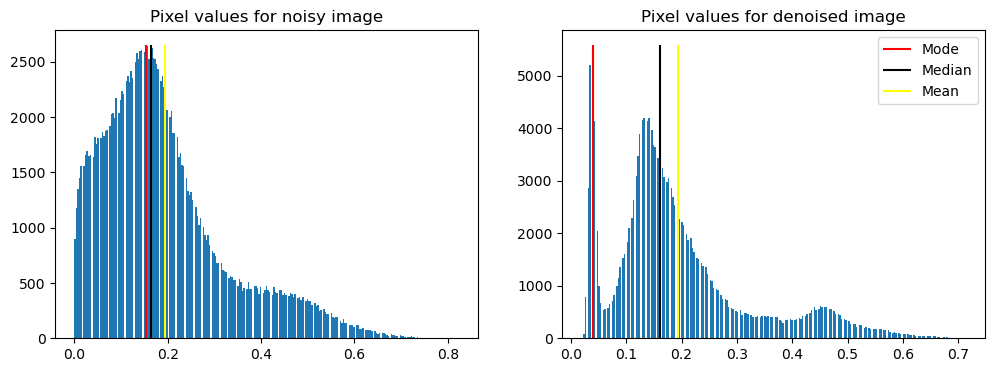

Mean square error between noisy image and denoised image: 0.002830120092699389
Structural similarity index between noisy image and denoised image 0.4821943840391292
----------------------------------------------------------------------------------------------------------------------------------
Standard deviation of pixel values in noisy image: 0.13628040978386483
Standard deviation of pixel values in denoised image: 0.12704407452723362
----------------------------------------------------------------------------------------------------------------------------------
Variance of Laplacian of noisy image 0.00619320751183851
Variance of Laplacian of denoised image 0.0005888604066572729


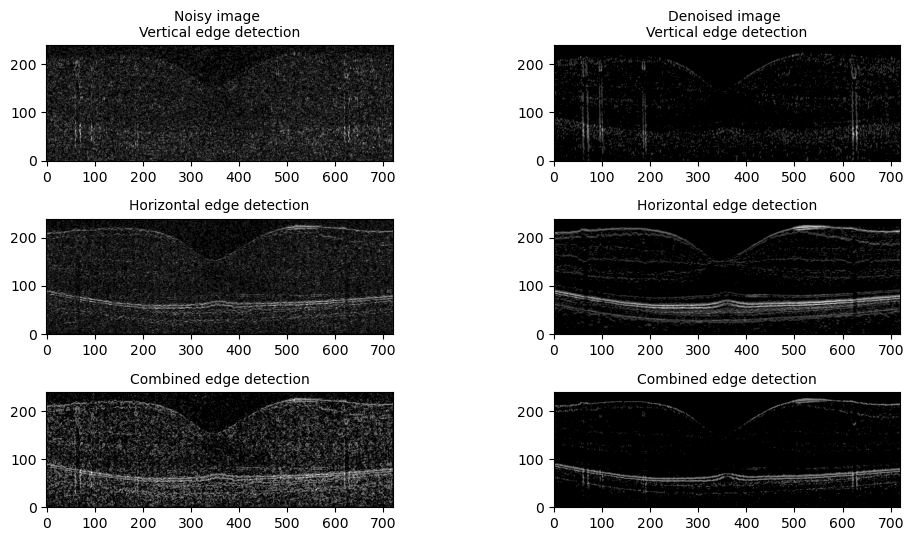

In [8]:
performance_metrics(image,GT)